## CESM LE run 2071-2100

**Author** : Sydney Crandall

**Last Revised** : August 10th, 2022

In [1]:
# imports
from pathlib import Path 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import pickle
import cartopy.crs as crt
from cartopy.util import add_cyclic_point
from matplotlib.gridspec import GridSpec
import datetime
import pandas as pd
import cesm_plot_and_extract as ext
import seaborn as sb
import datetime as dt
import cftime
import math
from matplotlib import ticker
import cesm_cluster as cluster
import cesm_visualizations as vis

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

In [2]:
fileroot = '/glade/work/scrandall/cesm_runs/archive/b.e11.BRCP85C5CNBDRD.f09_g16.001.2071-2100/atm/proc/tseries/day_1/b.e11.BRCP85C5CNBDRD.f09_g16.001.2071-2100.cam.h1.'
variableList = ['FSNS','PRECL','PRECT','PSL','QBOT','RELHUM','TMQ','TREFHT','TREFHTMN','TREFHTMX',
               'UBOT','VBOT','WSPDSRFAV','WSPDSRFMX']
timeSeries = ['.20710101-20801231.nc','.20810101-20901231.nc','.20910101-20991231.nc']

In [3]:
# read in data
# this function has been altered since the test runs, since the data is sectioned into 10 year intervals (per xarray)
dataDict = ext.read_xarray_data(fileroot,variableList,timeSeries)
adjust_variables = True
sel_RELHUM = True

In [4]:
# RELHUM is a 3d variable, for right now I'm just going to use the lowest level
if sel_RELHUM is True:
    dataDict['RELHUM'] = dataDict['RELHUM'].sel(lev = 992.6, method = 'nearest')
    sel_RELHUM = False

In [5]:
# Calculate Relative Humidity from specific humidity (QBOT), temperature (TREFHT), and pressure (PSL)
# This is more for fun than necessary, since RELHUM is now included in the model run

# use Clausius-Clapeyron equation

# RH = 0.263pq[exp((17.67)(T-Tnot)/(T-29.65))]^-1

num = 17.67*(dataDict['TREFHT']-273.15)
den = dataDict['TREFHT']-29.65
out = 0.263*dataDict['PSL']*dataDict['QBOT']
RH = xr.DataArray(out*(np.exp(num/den))**-1)
RH.name = 'RH_calculated'
RH.attrs = {'units':'%','long_name':'Calculated relative humidity (from PSL, QBOT, and TREFHT)','basename':'RH'}
dataDict[RH.name] = RH

# was having some issues with this in the test run where RH values >> 100%

In [6]:
# calculate temperature range between TREFHTMX and TREFHTMN

TRANGE = (dataDict['TREFHTMX'] - dataDict['TREFHTMN']).rename('TRANGE')
TRANGE.attrs = {'units':'deg_C','long_name':'calculated daily temperature difference (TREFHTMX-TREFHTMN)', 'basename':'TRANGE'}
dataDict[TRANGE.name] = TRANGE

In [7]:
# calculate wind direction from UBOT and VBOT

WDIR = 90 - np.arctan(dataDict['VBOT']/dataDict['UBOT'])*180/np.pi

# subset the UBOT, VBOT xarrays into ++, +-,--,-+ groups
for i in range(0,len(dataDict['UBOT'].values)):
    for j in range(0,len(dataDict['VBOT'].values[i])):
        for k in range(0,len(dataDict['UBOT'].values[i][j])):
            if dataDict['UBOT'].values[i][j][k] > 0 and dataDict['VBOT'].values[i][j][k] > 0:
                WDIR.values[i][j][k] = WDIR.values[i][j][k]
            elif dataDict['UBOT'].values[i][j][k] > 0 and dataDict['VBOT'].values[i][j][k] < 0:
                WDIR.values[i][j][k] = WDIR.values[i][j][k]
            elif dataDict['UBOT'].values[i][j][k] < 0 and dataDict['VBOT'].values[i][j][k] < 0:
                WDIR.values[i][j][k] = 180 + WDIR.values[i][j][k]
            elif dataDict['UBOT'].values[i][j][k] < 0 and dataDict['VBOT'].values[i][j][k] > 0:
                WDIR.values[i][j][k] = 180 + WDIR.values[i][j][k]

WDIR.name = 'WDIR'
WDIR.attrs = {'units':'degrees','long_name':'calculated lowest model level wind direction','basename':'WDIR'}
dataDict[WDIR.name] = WDIR

In [8]:
# calculate wind speed via pythagorian theorem
WSPD = ((dataDict['UBOT'])**2+(dataDict['VBOT'])**2)**0.5

WSPD.name = 'WSPD'
WSPD.attrs = {'units':'m/s','long_name':'calculated wind speed','basename':'WSPD'}
dataDict['WSPD'] = WSPD

In [9]:
# change the units on some of the features to make more sense

# Temperature variables: K to deg C (K - 273.15)
# wind variables: m/s to mph (m/s * 2.23694)
# precipitation variables: m/s to mm/day (m/s * 8.64e+7)
# pressure: pa to hPa (pa * 100)

if adjust_variables is True:
    
    dataDict['TREFHT'] = dataDict['TREFHT'] - 273.15
    dataDict['TREFHTMX'] = dataDict['TREFHTMX'] - 273.15
    dataDict['TREFHTMN'] = dataDict['TREFHTMN'] - 273.15

    dataDict['UBOT'] = dataDict['UBOT']*2.23694
    dataDict['VBOT'] = dataDict['VBOT']*2.23694
    dataDict['WSPDSRFAV'] = dataDict['WSPDSRFAV']*2.23694
    dataDict['WSPDSRFMX'] = dataDict['WSPDSRFMX']*2.23694
    dataDict['WSPD'] = dataDict['WSPD']*2.23694

    dataDict['PRECL'] = dataDict['PRECL']*8.64e7
    dataDict['PRECT'] = dataDict['PRECT']*8.64e7

    dataDict['PSL'] = dataDict['PSL']/100
    
    adjust_variabels = False

In [10]:
# add back in the attributes that were lost by adjusting units
dataDict['PRECL'].attrs = {'units':'mm_day','long_name':'Large-scale (stable) precipitation rate (liq + ice)', 'cell_methods':'time:mean', 'basename':'PRECL'}
dataDict['PRECT'].attrs = {'units':'mm_day','long_name':'Total (convective and large-scale) precipitation rate (liq + ice)','cell_methods':'time:mean','basename':'PRECT'}
dataDict['PSL'].attrs = {'units': 'hPa', 'long_name': 'Sea level pressure', 'cell_methods': 'time: mean', 'basename': 'PSL'}
dataDict['TREFHT'].attrs = {'units': 'deg_C', 'long_name': 'Reference height temperature', 'cell_methods': 'time: mean', 'basename': 'TREFHT'}
dataDict['TREFHTMX'].attrs = {'units': 'deg_C', 'long_name': 'Maximum reference height temperature over output period', 'cell_methods': 'time: maximum', 'basename': 'TREFHTMX'}
dataDict['TREFHTMN'].attrs = {'units': 'deg_C', 'long_name': 'Minimum reference height temperature over output period', 'cell_methods': 'time: minimum', 'basename': 'TREFHTMN'}
dataDict['UBOT'].attrs = {'units': 'mph', 'long_name': 'Lowest model level zonal wind', 'basename': 'UBOT'}
dataDict['VBOT'].attrs = {'units': 'mph', 'long_name': 'Lowest model level meridional wind', 'basename': 'VBOT'}
dataDict['WSPD'].attrs = {'units':'mph','long_name':'Calculated lowest model level wind speed','basename':'WSPD'}
dataDict['WSPDSRFAV'].attrs = {'units': 'mph', 'long_name': 'Horizontal total wind speed average at the surface', 'cell_methods': 'time: mean', 'basename': 'WSPDSRFAV'}
dataDict['WSPDSRFMX'].attrs = {'units': 'mph', 'long_name': 'Horizontal total wind speed maximum at the surface', 'cell_methods': 'time: maximum', 'basename': 'WSPDSRFMX'}

In [11]:
keyList = []
for key, value in dataDict.items():
    print(key)
    keyList.append(key)
keyList.remove('RELHUM')

FSNS
PRECL
PRECT
PSL
QBOT
RELHUM
TMQ
TREFHT
TREFHTMN
TREFHTMX
UBOT
VBOT
WSPDSRFAV
WSPDSRFMX
RH_calculated
TRANGE
WDIR
WSPD


In [12]:
locationList = ['elp','alb','trd','bou','cas','bil','gls']
minLatList = [31,35,37,40,42,45,48]
maxLatList = [32,36,38,40.5,43,46,49]
minLonList = [253,253,254,254,253,251,253]
maxLonList = [254,254,256,256,254,252,254]
locationDfList = []
dfList = [] 
columns_to_drop = []
for k in range(0,len(keyList)):
    print(keyList[k])
    column_name = keyList[k]+'_'+dataDict[keyList[k]].attrs['units']
    for i in range(0,len(locationList)):
        #select the correct location
        location_data = dataDict[keyList[k]].sel(lat = slice(minLatList[i],maxLatList[i])).sel(lon = slice(minLonList[i],maxLonList[i]))
        # convert xarray to dataframe
        location_df = location_data.to_dataframe()
        # rename the column to something unique
        location_df.rename({keyList[k]:column_name+str(i)}, axis = 1, inplace = True)
        # append the new dataframe to dfList
        locationDfList.append(location_df)
    # combine the locations into one dataframe, all one variable
    variable_df = pd.concat(locationDfList, axis = 1)
    # create a column for the variable, populated with NaN
    variable_df[column_name] = np.NaN
    # iterate through the locations
    for j in range(0,len(locationList)):
        # fill the NaN values in the new column with the values from the location column
        variable_df[column_name].fillna(variable_df[column_name+str(j)], inplace = True)
        columns_to_drop.append(column_name+str(j))
        # add variable_df to the dfList
    dfList.append(variable_df)
    
# combine all variable_df's in the dfList
df = pd.concat(dfList, axis = 1)
df.drop(columns_to_drop, inplace  = True, axis = 1)

FSNS
PRECL
PRECT
PSL
QBOT
TMQ
TREFHT
TREFHTMN
TREFHTMX
UBOT
VBOT
WSPDSRFAV
WSPDSRFMX
RH_calculated
TRANGE
WDIR
WSPD


In [13]:
df

FSNS_W/m2  PRECL_mm_day  PRECT_mm_day  \
time                lat       lon                                             
2071-01-01 00:00:00 31.570681 253.75  -0.107399      0.088466      0.556703   
                    35.340314 253.75   0.000000      0.839537      3.800796   
                    37.225131 255.00   0.000000      8.078455      8.078455   
                    40.052356 255.00   0.000000      5.209897      5.209897   
                    42.879581 253.75   0.000000      0.380729      0.380729   
...                                         ...           ...           ...   
2100-01-01 00:00:00 37.225131 255.00  77.660049      0.179354      0.179354   
                    40.052356 255.00  65.710251      0.611747      0.611747   
                    42.879581 253.75  45.126965      0.774527      0.774527   
                    45.706806 251.25  31.946321      2.084668      2.084668   
                    48.534031 253.75  49.038853      0.077070      0.077070   

                                          PSL_hPa  QBOT_kg/kg  TMQ_kg/m2  \
time                lat       lon                                          
2071-01-01 00:00:00 31.570681 253.75  1007.710693    0.004246   9.934567   
                    35.340314 253.75  1014.699219    0.003318   5.545779   
                    37.225131 255.00  1021.520874    0.002594   3.886467   
                    40.052356 255.00  1032.998779    0.001761   2.829420   
                    42.879581 253.75  1037.840698    0.001478   2.608144   
...                                           ...         ...        ...   
2100-01-01 00:00:00 37.225131 255.00  1017.723572    0.003266   6.848315   
                    40.052356 255.00  1019.862915    0.003536   7.458026   
                    42.879581 253.75  1024.247192    0.002866   7.378817   
                    45.706806 251.25  1028.904541    0.001865   6.061200   
                    48.534031 253.75  1035.099121    0.001110   3.092869   

                                      TREFHT_deg_C  TREFHTMN_deg_C  \
time                lat       lon                                    
2071-01-01 00:00:00 31.570681 253.75      9.884125        9.884125   
                    35.340314 253.75     -1.992767       -1.992767   
                    37.225131 255.00     -7.702698       -7.702698   
                    40.052356 255.00    -11.628967      -11.628967   
                    42.879581 253.75    -11.635956      -11.635956   
...                                            ...             ...   
2100-01-01 00:00:00 37.225131 255.00     -0.188843       -2.420166   
                    40.052356 255.00     -3.521179       -6.832092   
                    42.879581 253.75     -7.230591      -11.790375   
                    45.706806 251.25    -12.222626      -15.676941   
                    48.534031 253.75    -13.922974      -16.142883   

                                      TREFHTMX_deg_C  UBOT_mph  VBOT_mph  \
time                lat       lon                                          
2071-01-01 00:00:00 31.570681 253.75        9.884125  7.906575 -4.110898   
                    35.340314 253.75       -1.992767  4.590895 -4.628966   
                    37.225131 255.00       -7.702698 -8.663194 -4.847361   
                    40.052356 255.00      -11.628967 -3.068192 -6.785018   
                    42.879581 253.75      -11.635956  0.718158 -7.085570   
...                                              ...       ...       ...   
2100-01-01 00:00:00 37.225131 255.00        3.307892  2.160906  2.667887   
                    40.052356 255.00        2.415924  3.098088  0.449602   
                    42.879581 253.75        0.427582  2.437743  2.465553   
                    45.706806 251.25       -8.424713 -6.140357 -5.266584   
                    48.534031 253.75      -10.891632  0.982391 -5.485738   

                                      WSPDSRFAV_mph  WSPDSRFMX_mph  \
time                lat       lon                  

In [15]:
# save DataFrame to work
df.to_csv('/glade/work/scrandall/cluster_data_2071_2100.csv')

In [16]:
# monthly plots

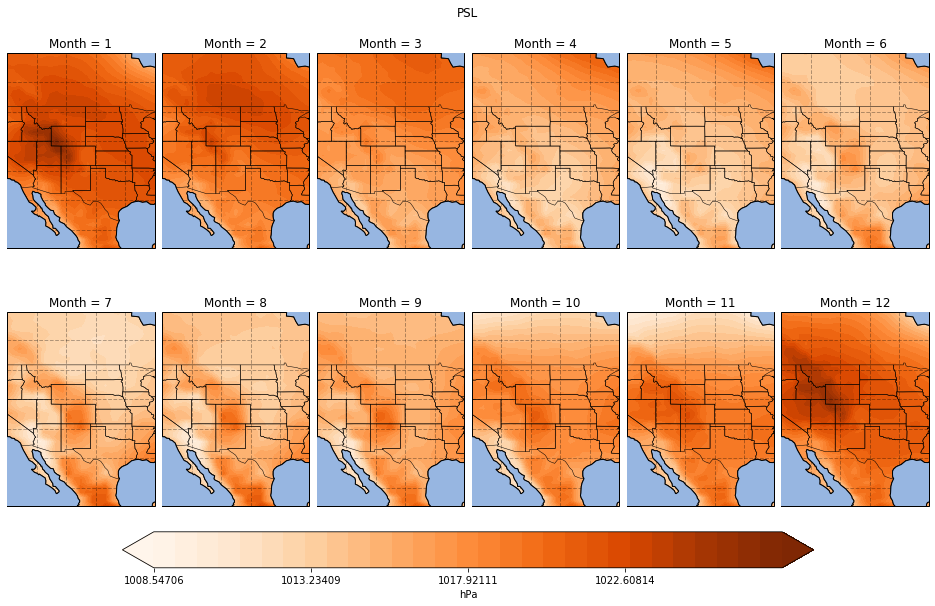

In [17]:
ext.plots_by_month(dataDict['PSL'],'pres',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/PSL.jpg')

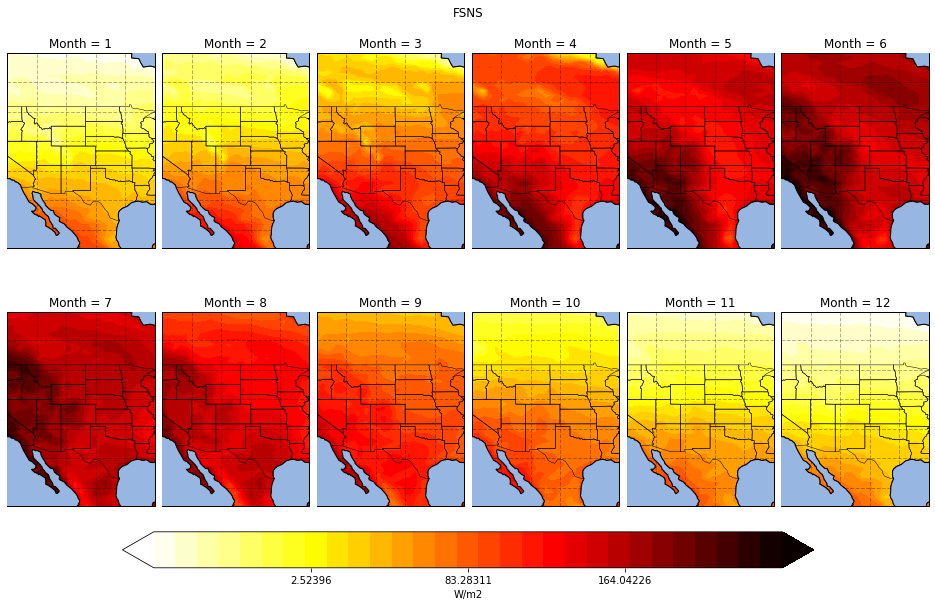

In [18]:
ext.plots_by_month(dataDict['FSNS'],'misc',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/FSNS.jpg')

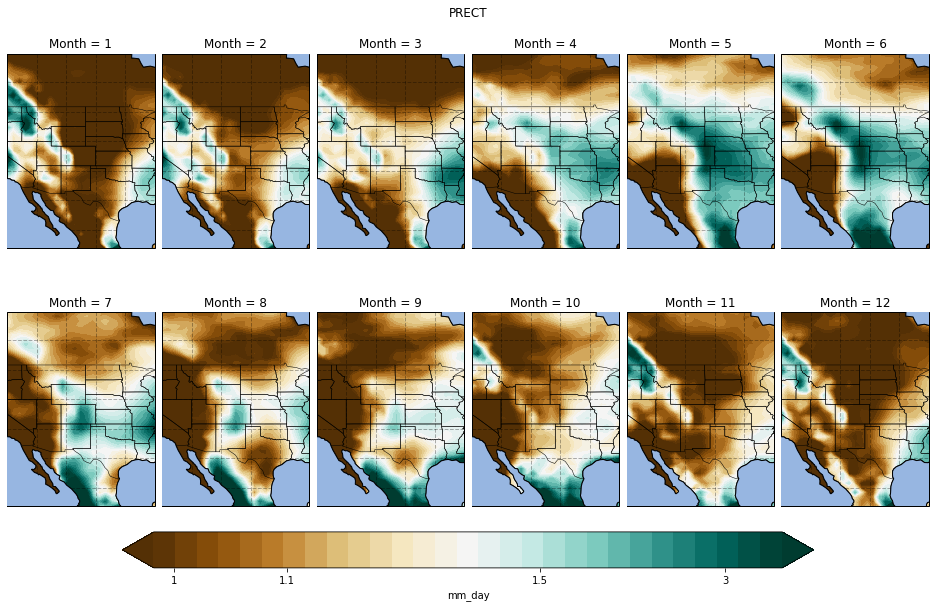

In [19]:
ext.plots_by_month(dataDict['PRECT'],'prec',log = True, save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/PRECT.jpg')

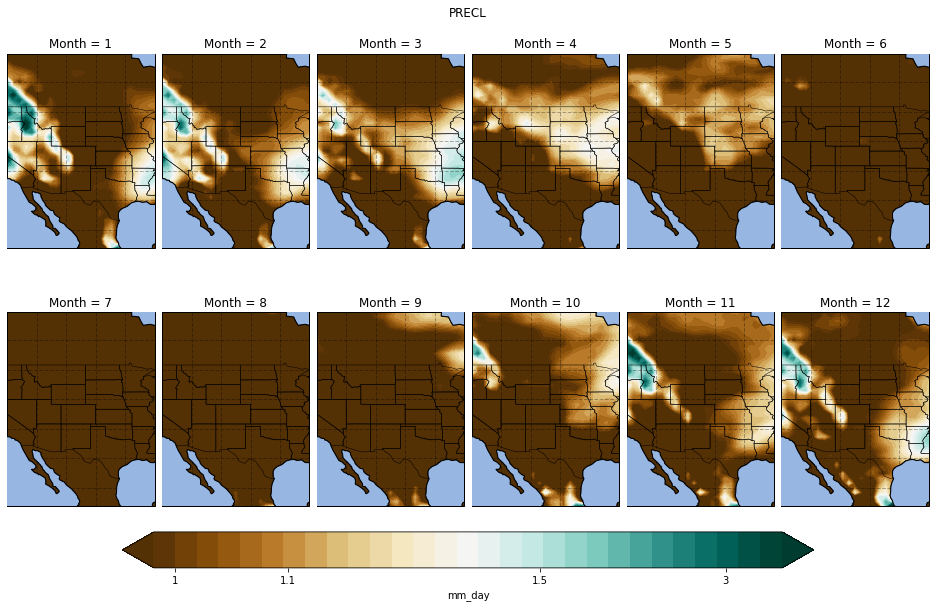

In [20]:
ext.plots_by_month(dataDict['PRECL'],'prec',log = True, save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/PRECL.jpg')

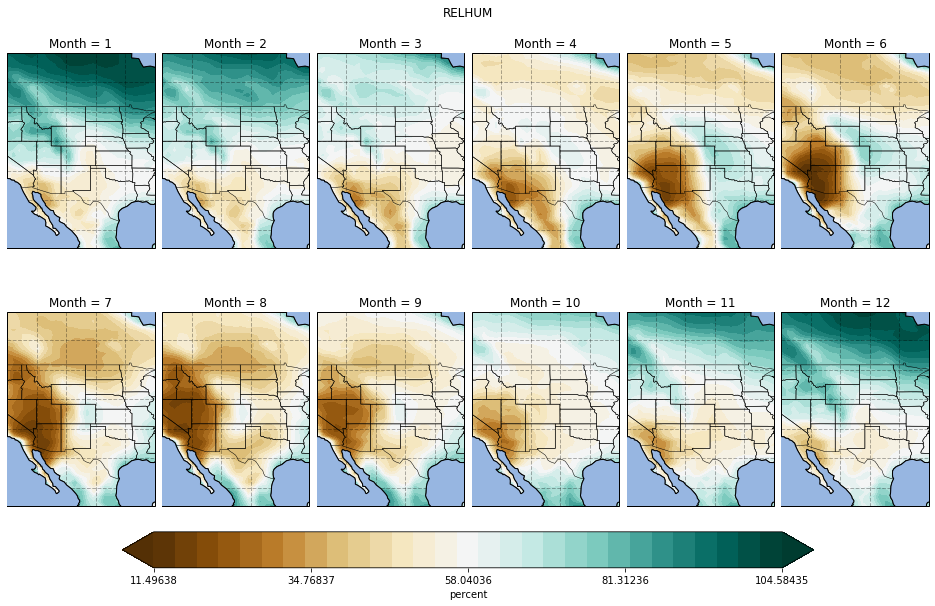

In [21]:
ext.plots_by_month(dataDict['RELHUM'],'hum', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/RELHUM.jpg')

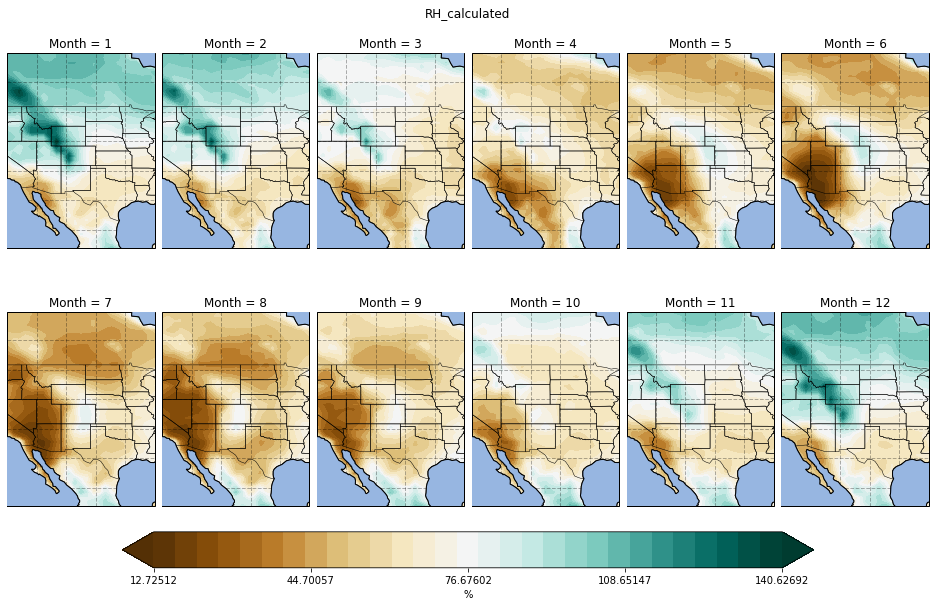

In [22]:
ext.plots_by_month(dataDict['RH_calculated'], 'hum')

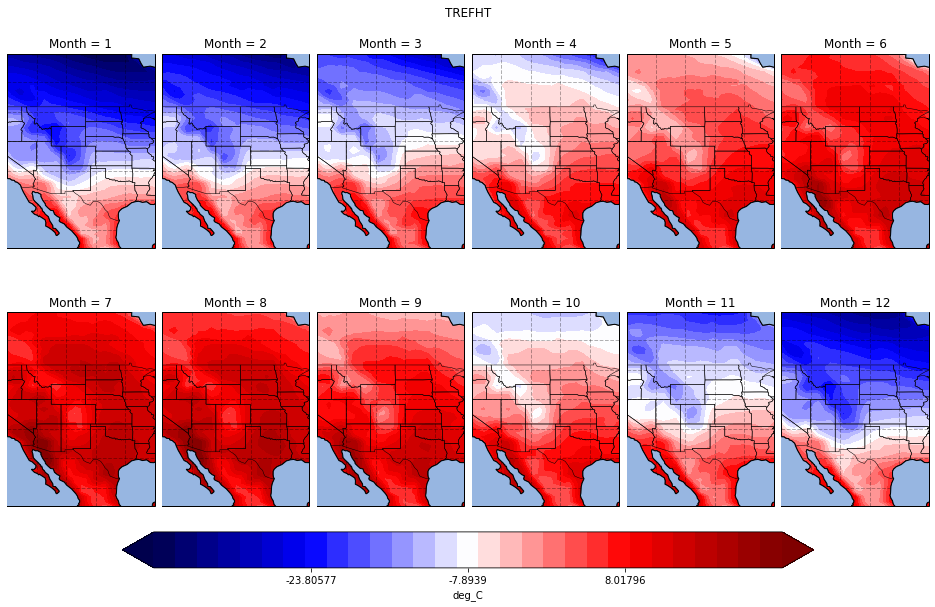

In [23]:
ext.plots_by_month(dataDict['TREFHT'],'temp',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/TREFHT.jpg')

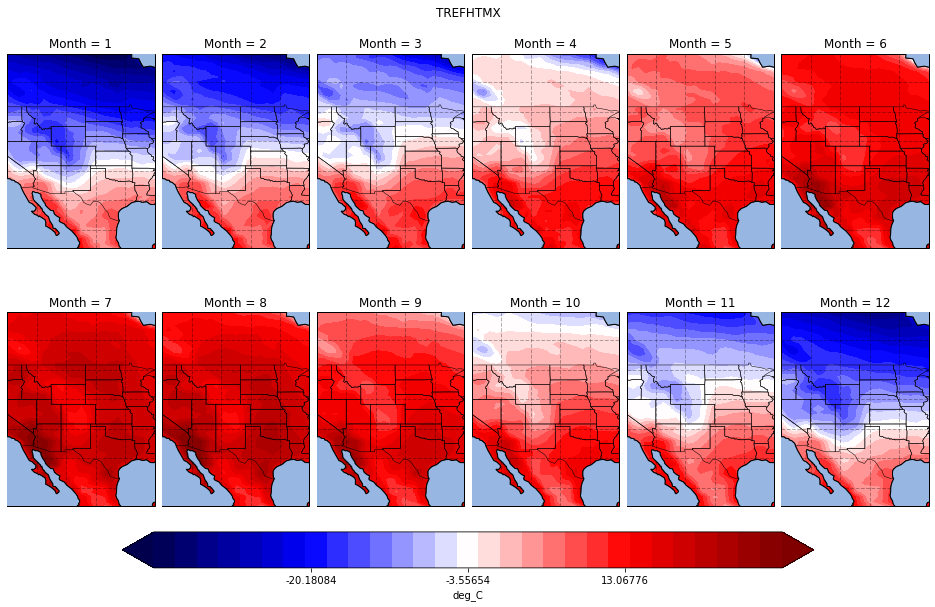

In [24]:
ext.plots_by_month(dataDict['TREFHTMX'],'temp',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/TREFHTMX.jpg')

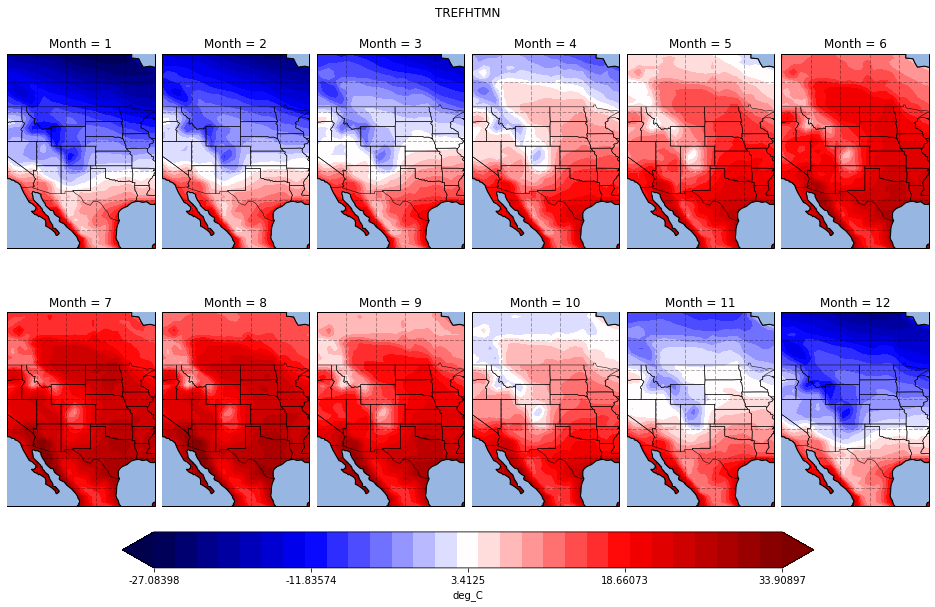

In [25]:
ext.plots_by_month(dataDict['TREFHTMN'],'temp',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/TREFHTMN.jpg')

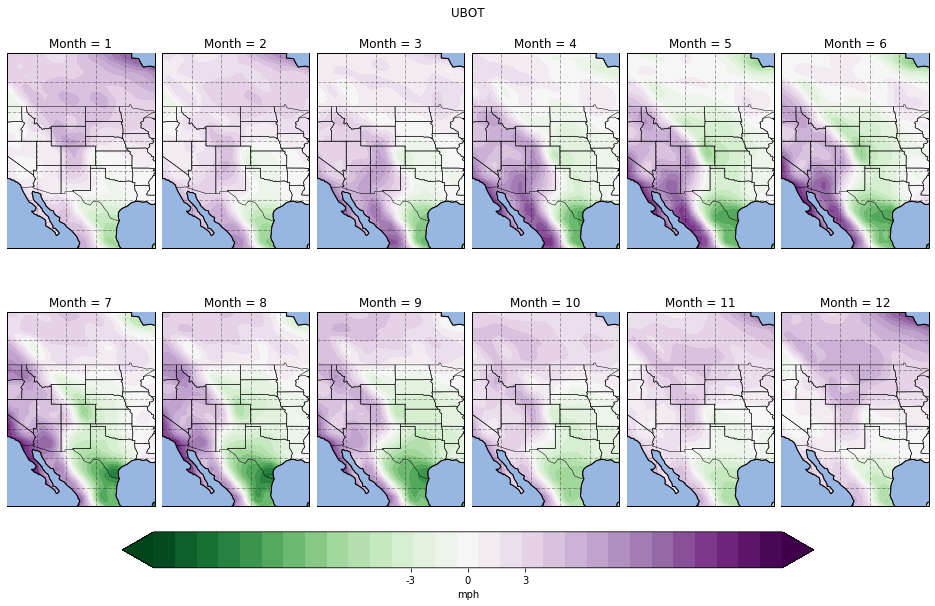

In [26]:
ext.plots_by_month(dataDict['UBOT'],'UV',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/UBOT.jpg')

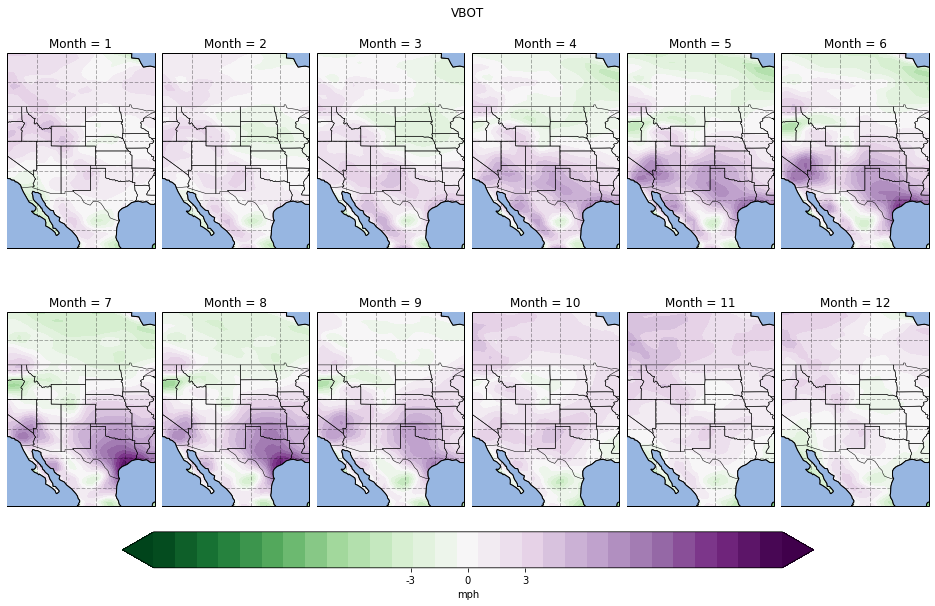

In [27]:
ext.plots_by_month(dataDict['VBOT'],'UV', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/VBOT.jpg')

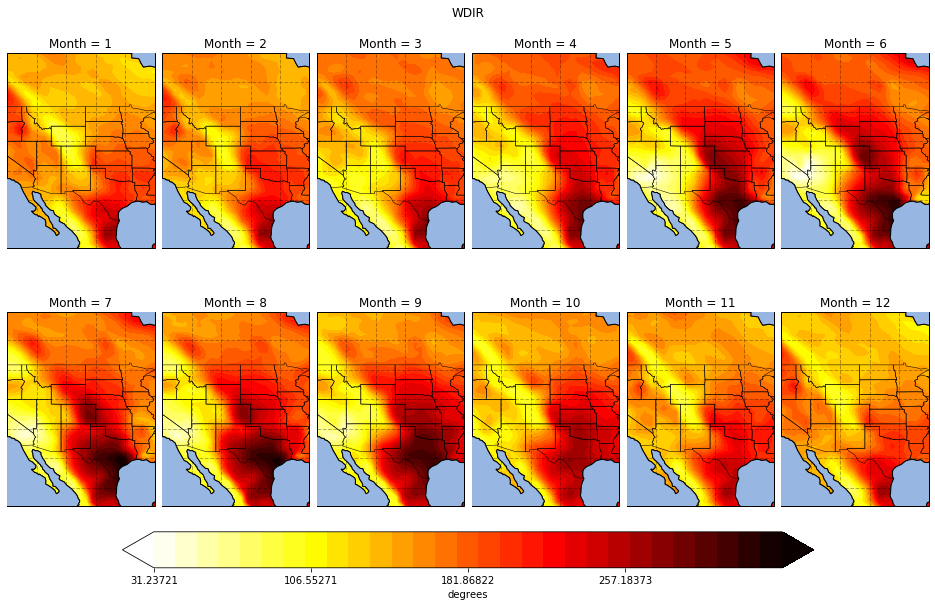

In [28]:
ext.plots_by_month(dataDict['WDIR'],'misc',save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/WDIR.jpg')
# check this one, 180 should be closer to the middle

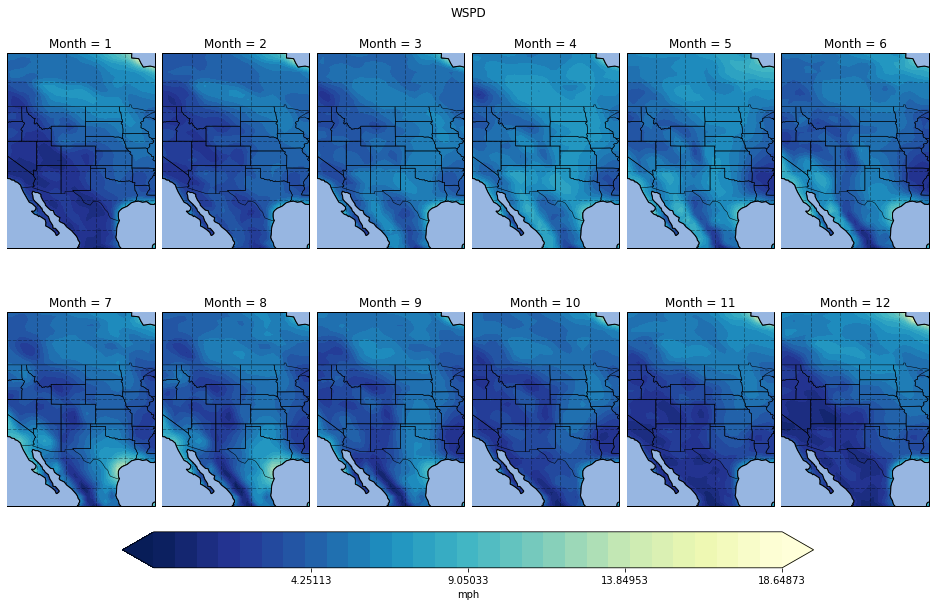

In [29]:
ext.plots_by_month(dataDict['WSPD'],'wspd', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/WSPD.jpg')

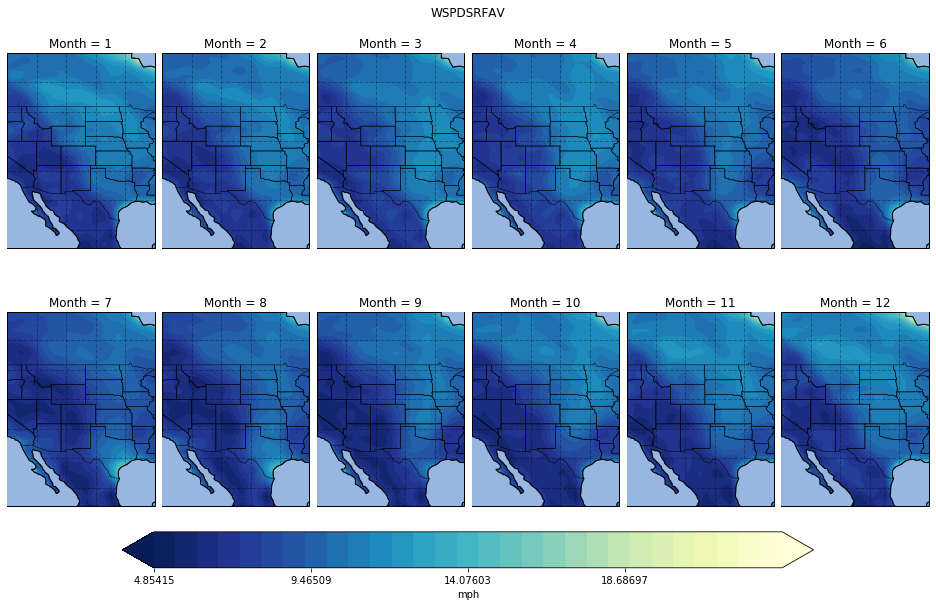

In [30]:
ext.plots_by_month(dataDict['WSPDSRFAV'], 'wspd', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/WSPDSRFAV.jpg')

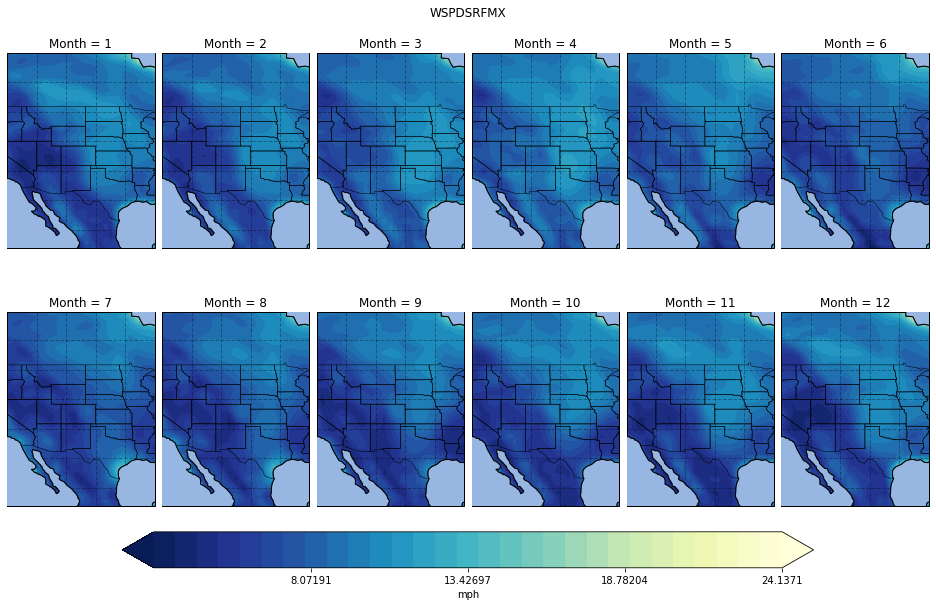

In [31]:
ext.plots_by_month(dataDict['WSPDSRFMX'], 'wspd', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/WSPDSRFMX.jpg')

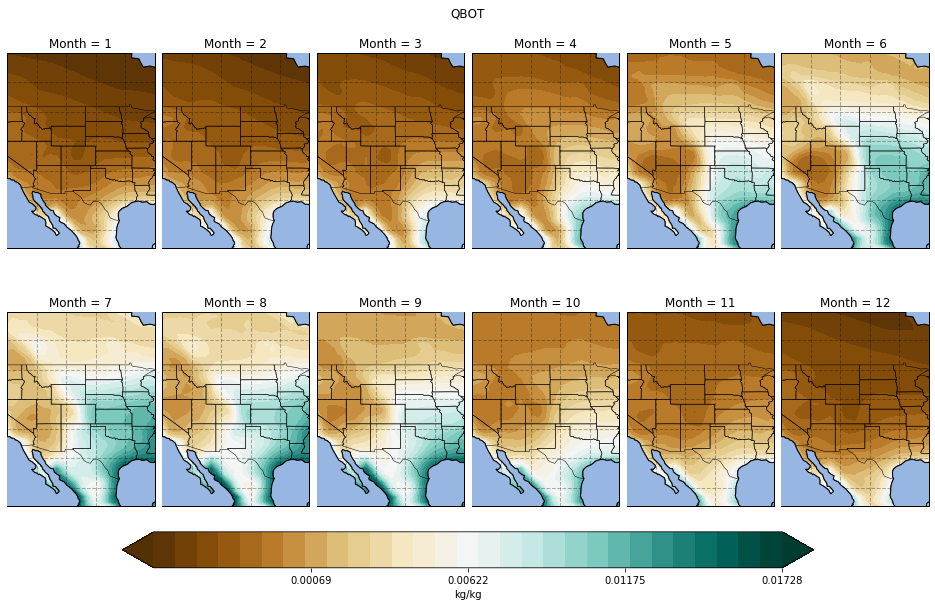

In [32]:
ext.plots_by_month(dataDict['QBOT'], 'hum', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/QBOT.jpg')

In [ ]:
ext.plots_by_month(dataDict['TMQ'], 'prec', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/TMQ.jpg')

In [ ]:
ext.plots_by_month(dataDict['TRANGE'],'temp', save = True, figname = '/glade/u/home/scrandall/production_2071_2100_plots/TRANGE.jpg')
# change this to a non-diverging color scale, possibly just red?